cuda:1
Agent training (episode17) Avg Reward 0.0:   0%|          | 11/5001 [00:00<04:37, 17.96it/s]/root/labs/RTML/lab14/DQN_Net.py:46: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state   = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
Agent training (episode65) Avg Reward 0.23076923076923078:   1%|          | 45/5001 [00:05<10:15,  8.06it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
Agent training (episode5001) Avg Reward 0.4839032193561288: 100%|██████████| 5001/5001 [01:21<00:00, 61.27it/s]


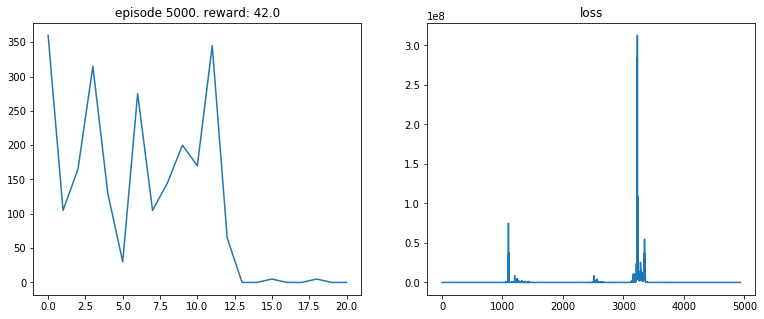

In [3]:
import math, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as T

from PIL import Image
import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm import trange
from DQN_Net import ReplayBuffer, DDQN, NaivePrioritizedBuffer
# Select GPU or CPU as device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

def plot(episode, rewards, losses):
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)   
    plt.show()

# Define epsilon as a function of time (episode index)
def gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay):
    eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)
    return eps_by_episode

# episodes = 200000
episodes = 5000
batch_size = 64
gamma      = 0.99
min_play_reward = -.15

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = episodes / 10
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

# defind a function to return an increasing beta over episodes
beta_start = 0.4
beta_episodes = episodes / 10
def gen_beta_by_episode(beta_start, beta_episodes):
    beta_by_episode = lambda episode: min(1.0, beta_start + episode * (1.0 - beta_start) / beta_episodes)
    return beta_by_episode

beta_by_episode = gen_beta_by_episode(beta_start, beta_episodes)


def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

env_id = 'SpaceInvaders-v0'
env = gym.make(env_id)

current_model = DDQN(4, env.action_space.n).to(device)
target_model  = DDQN(4, env.action_space.n).to(device)

optimizer = optim.Adam(current_model.parameters())

# Change from Normal replay buffer to be prioritize buffer
#replay_buffer = ReplayBuffer(100000)
replay_buffer = NaivePrioritizedBuffer(100000)

update_target(current_model, target_model)

image_size = 84
transform = T.Compose([T.ToPILImage(),
                       T.Grayscale(num_output_channels=1),
                       T.Resize((image_size, image_size), interpolation=Image.CUBIC),
                       T.ToTensor()])

# Convert to RGB image (3 channels)
import queue
state_buffer = queue.Queue()
def get_state3(observation):
    
    # First time, repeat the state for 3 times
    if(state_buffer.qsize() == 0):
        for i in range(4):
            state = get_state2(observation)
            state_buffer.put(state)
        # print(observation.shape, state.shape)
    else:
        state_buffer.get()
        state = get_state2(observation)
        state_buffer.put(state)
    # for i in state_buffer.queue:
    #     print(i.shape)
    rep = torch.cat(list(state_buffer.queue), dim=0)
    # print("rep=====",rep.shape)
    return rep

def get_state2(observation):
    state = observation.transpose((2,0,1))
    state = torch.from_numpy(state)
    state = transform(state)
    return state
    
def compute_td_loss_DDQN_prior_exp_replay(current_model, target_model, batch_size, gamma=0.99, beta=0.4):
    # get data from replay mode
    # state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    state, action, reward, next_state, done, indices, weights = replay_buffer.sample(batch_size, beta)

    # convert to tensors
    # Autograd automatically supports Tensors with requires_grad set to True.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)
    weights    = autograd.Variable(torch.FloatTensor(weights)).to(device)

    # calculate q-values and next q-values from deeplearning
    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    # double DQN add here
    #next_q_state_values = target_model(next_state)

    # get q-value from propagated action in each step
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    # double DQN different here
    #next_q_value     = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    # calculate expected q-value from q-function
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # calculate loss value
    # loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
    loss = (q_value - expected_q_value.detach()).pow(2).mean()
    prios = loss + 1e-5
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    replay_buffer.update_priorities(indices, prios.data.cpu().numpy())
    optimizer.step()

    return loss

def train_DDQN_prior_exp_replay(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, beta_by_episode, episodes = 10000, batch_size=32, gamma = 0.99, min_play_reward=-.15):
    losses = []
    all_rewards = []
    episode_reward = 0

    obs = env.reset()
    state = get_state3(obs)
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)
    for episode in tr:
        avg_reward = tot_reward / (episode + 1)
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,avg_reward))
        tr.refresh() 

        # get action with q-values
        epsilon = eps_by_episode(episode)
        action = current_model.act(state, epsilon, env, device)
        
        # input action into state
        reward = 0
        for i in range(3):
            next_obs, i_reward, done, _ = env.step(action)
            reward += i_reward
            if(done): break
        next_state = get_state3(next_obs)
        # save data into buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        
        state = next_state
        obs = next_obs
        episode_reward += reward
        
        if done:
            obs = env.reset()
            state = get_state3(obs)
            all_rewards.append(episode_reward)
            episode_reward = 0
            
        if len(replay_buffer) > batch_size:
            beta = beta_by_episode(episode)
            loss = compute_td_loss_DDQN_prior_exp_replay(current_model, target_model, batch_size, gamma, beta)
            losses.append(loss.item())

        if episode % 500 == 0:
            update_target(current_model, target_model)
            
    plot(episode, all_rewards, losses)  
    return current_model, target_model, all_rewards, losses

current_model, target_model, all_rewards, losses = train_DDQN_prior_exp_replay(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, beta_by_episode, episodes = episodes, batch_size=batch_size, gamma = gamma, min_play_reward = min_play_reward)
torch.save(current_model.state_dict(), 'checkpoints/spaceInvaders-hw-phi-skip-1M.pth')
torch.save(target_model.state_dict(), 'checkpoints/spaceInvaders-target-hw-phi-skip-1M.pth')


### Report
For spaceinvader inference, I cannot run because of env.render() functions not working o my container.